# Agentenbasiertes Kreditrisikomodell (Variante)
Dieses Notebook implementiert ein agentenbasiertes Modell zur Bewertung von Kreditrisiken. Anpassbare Parameter:
- **num_months**: Simulationsdauer in Monaten
- **num_agents**: Anzahl der Kreditnehmer
- **prob_default**: Basis-Ausfallwahrscheinlichkeit pro Monat
- **interest_rate**: Zinssatz pro Monat
- **recovery_rate**: Rückgewinnung nach Ausfall
- **initial_loan**: Anfangsdarlehensbetrag pro Agent
- **seed**: Zufalls-Seed


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
import json
import random
from pathlib import Path
from openai import OpenAI
import warnings
warnings.filterwarnings('ignore')

# OpenAI API key
credentials = json.loads(Path('../../credentials.json').read_text())['openai']
api_key = credentials.get('api_key')

# Create OpenAI client
client = OpenAI(api_key=api_key)

print("OpenAI Client erfolgreich initialisiert!")

OpenAI Client erfolgreich initialisiert!


In [31]:
# Modell-Parameter (optimiert für AI-Integration)
num_months = 12         # Simulationsdauer in Monaten
num_agents = 15         # Anzahl der Kreditnehmer-Agenten (reduziert für AI-Integration)
prob_default = 0.03     # Basis-Ausfallwahrscheinlichkeit pro Monat
interest_rate = 0.08    # Monatlicher Zinssatz
recovery_rate = 0.5     # Rückgewinnungsrate im Ausfallfall
initial_loan = 1000     # Anfangsdarlehensbetrag pro Agent
seed = 123              # Zufalls-Seed für Reproduzierbarkeit

# AI-Parameter
use_ai = True           # ✅ AI AKTIVIERT - ChatGPT für realistische Entscheidungen
ai_model = "gpt-3.5-turbo"  # OpenAI Modell

# Setze Random Seed
np.random.seed(seed)
random.seed(seed)

print(f"🤖 AI-AKTIVIERTE KONFIGURATION:")
print(f"  - {num_agents} Agenten (optimiert für AI)")
print(f"  - {num_months} Monate")
print(f"  - AI aktiviert: {use_ai} ✅")
print(f"  - Modell: {ai_model}")
print(f"  - Erwartete Laufzeit: ~2-3 Minuten")
print(f"  - Hinweis: AI macht realistische Entscheidungen basierend auf Agenten-Profilen!")

🤖 AI-AKTIVIERTE KONFIGURATION:
  - 15 Agenten (optimiert für AI)
  - 12 Monate
  - AI aktiviert: True ✅
  - Modell: gpt-3.5-turbo
  - Erwartete Laufzeit: ~2-3 Minuten
  - Hinweis: AI macht realistische Entscheidungen basierend auf Agenten-Profilen!


In [32]:
import numpy as np
import random

class Agent:
    PROFILES = ["vorsichtig", "impulsiv", "pechvogel", "diszipliniert"]
    
    def __init__(self, agent_id, prob_default, interest_rate, recovery_rate, initial_loan, use_ai=False):
        self.agent_id = agent_id
        self.prob_default = prob_default
        self.interest_rate = interest_rate
        self.recovery_rate = recovery_rate
        self.initial_loan = initial_loan
        self.balance = initial_loan
        self.alive = True
        self.time_to_default = None
        self.use_ai = use_ai
        
        # Erweiterte Agenten-Eigenschaften
        self.profile = random.choice(self.PROFILES)
        self.credit_score = random.randint(500, 850)
        self.income = self.simulate_income()
        self.expenses = self.simulate_expenses()
        self.payment_history = []
        self.stress_level = random.uniform(0.1, 0.9)
        
        # Angepasste Ausfallwahrscheinlichkeit basierend auf Profil
        self.adjusted_prob_default = self.calculate_adjusted_default_prob()
        
    def simulate_income(self):
        """Simuliert monatliches Einkommen basierend auf Credit Score"""
        base_income = 2000 + (self.credit_score - 500) * 5
        return random.randint(int(base_income * 0.8), int(base_income * 1.3))
    
    def simulate_expenses(self):
        """Simuliert monatliche Ausgaben basierend auf Profil"""
        if self.profile == "vorsichtig":
            return random.randint(int(self.income * 0.4), int(self.income * 0.6))
        elif self.profile == "impulsiv":
            return random.randint(int(self.income * 0.7), int(self.income * 0.95))
        elif self.profile == "pechvogel":
            return random.randint(int(self.income * 0.5), int(self.income * 0.8)) + random.randint(200, 800)
        elif self.profile == "diszipliniert":
            return random.randint(int(self.income * 0.3), int(self.income * 0.5))
        
    def calculate_adjusted_default_prob(self):
        """Berechnet angepasste Ausfallwahrscheinlichkeit"""
        base_prob = self.prob_default
        
        # Profil-basierte Anpassung
        if self.profile == "vorsichtig":
            base_prob *= 0.7
        elif self.profile == "impulsiv":
            base_prob *= 1.4
        elif self.profile == "pechvogel":
            base_prob *= 1.6
        elif self.profile == "diszipliniert":
            base_prob *= 0.5
            
        # Credit Score Anpassung
        if self.credit_score > 750:
            base_prob *= 0.6
        elif self.credit_score < 600:
            base_prob *= 1.5
            
        return min(base_prob, 0.5)  # Maximal 50% Ausfallwahrscheinlichkeit
    
    def generate_ai_prompt(self, month):
        """Generiert optimierten Prompt für AI-basierte Entscheidung"""
        disposable_income = self.income - self.expenses
        payment_amount = self.balance * self.interest_rate
        
        # Profil-spezifische Kontext-Information
        profile_context = {
            "vorsichtig": "Sie sind sehr vorsichtig mit Geld und zahlen normalerweise pünktlich.",
            "impulsiv": "Sie sind impulsiv und geben manchmal mehr aus als geplant.",
            "pechvogel": "Sie haben oft unerwartete Ausgaben und finanzielle Schwierigkeiten.",
            "diszipliniert": "Sie sind sehr diszipliniert und verwalten Ihre Finanzen streng."
        }
        
        return f"""Sie sind ein {self.profile}er Kreditnehmer. {profile_context[self.profile]}

Finanzielle Lage:
- Einkommen: {self.income}€/Monat
- Ausgaben: {self.expenses}€/Monat  
- Verfügbar: {disposable_income}€/Monat
- Kreditrate: {payment_amount:.0f}€
- Credit Score: {self.credit_score}

Können Sie diesen Monat die Rate zahlen?
Antworten Sie nur mit: ZAHLEN oder AUSFALL"""
    
    def make_ai_decision(self, month):
        """Trifft AI-basierte Entscheidung über Zahlung"""
        try:
            response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": "Sie entscheiden als Kreditnehmer über Ratenzahlungen basierend auf Ihrer finanziellen Situation und Ihrem Persönlichkeitstyp."},
                    {"role": "user", "content": self.generate_ai_prompt(month)}
                ],
                temperature=0.7,
                max_tokens=5
            )
            
            decision = response.choices[0].message.content.strip().upper()
            return "ZAHLEN" in decision
            
        except Exception as e:
            print(f"🤖 AI-Entscheidung fehlgeschlagen für Agent {self.agent_id}: {e}")
            # Fallback auf probabilistische Entscheidung
            return np.random.rand() > self.adjusted_prob_default
    
    def step(self, month):
        """Führt einen Simulationsschritt durch"""
        if not self.alive:
            return 0
            
        # Entscheidung über Zahlung
        if self.use_ai:
            can_pay = self.make_ai_decision(month)
        else:
            can_pay = np.random.rand() > self.adjusted_prob_default
            
        if not can_pay:
            # Ausfall
            self.alive = False
            self.time_to_default = month
            loss = self.balance * (1 - self.recovery_rate)
            return -loss
        else:
            # Erfolgreiche Zahlung
            payment = self.balance * self.interest_rate
            self.balance += payment
            self.payment_history.append(month)
            return payment


In [33]:
def simulate(num_agents, num_months, prob_default, interest_rate, recovery_rate, initial_loan, use_ai=False):
    """
    Erweiterte Simulationsfunktion mit detaillierter Analyse
    """
    agents = [Agent(i, prob_default, interest_rate, recovery_rate, initial_loan, use_ai) 
              for i in range(num_agents)]
    
    records = []
    
    print(f"Starte Simulation mit {num_agents} Agenten über {num_months} Monate...")
    print(f"AI-Modus: {'Aktiviert' if use_ai else 'Deaktiviert'}")
    
    for month in trange(1, num_months+1, desc='Simulation läuft'):
        gains = []
        defaults_this_month = 0
        
        for agent in agents:
            gain = agent.step(month)
            gains.append(gain)
            if agent.time_to_default == month:
                defaults_this_month += 1
        
        # Berechne Statistiken für diesen Monat
        monthly_gain = sum(gains)
        active_agents = sum(1 for agent in agents if agent.alive)
        
        records.append({
            'Month': month,
            'MonthlyGain': monthly_gain,
            'CumulativeGain': sum(record['MonthlyGain'] for record in records) + monthly_gain,
            'Defaults': defaults_this_month,
            'ActiveAgents': active_agents,
            'DefaultRate': defaults_this_month / num_agents if num_agents > 0 else 0
        })
    
    return pd.DataFrame(records), agents

def analyze_agents(agents):
    """Analysiert die Agenten nach der Simulation"""
    profile_analysis = {}
    
    for profile in Agent.PROFILES:
        profile_agents = [a for a in agents if a.profile == profile]
        if profile_agents:
            defaults = sum(1 for a in profile_agents if not a.alive)
            profile_analysis[profile] = {
                'total': len(profile_agents),
                'defaults': defaults,
                'default_rate': defaults / len(profile_agents),
                'avg_credit_score': np.mean([a.credit_score for a in profile_agents]),
                'avg_income': np.mean([a.income for a in profile_agents])
            }
    
    return profile_analysis

KREDITRISIKO-SIMULATION MIT AI-INTEGRATION
Starte Simulation mit 15 Agenten über 12 Monate...
AI-Modus: Aktiviert


Simulation läuft:   0%|          | 0/12 [00:00<?, ?it/s]

Simulation läuft: 100%|██████████| 12/12 [00:45<00:00,  3.82s/it]



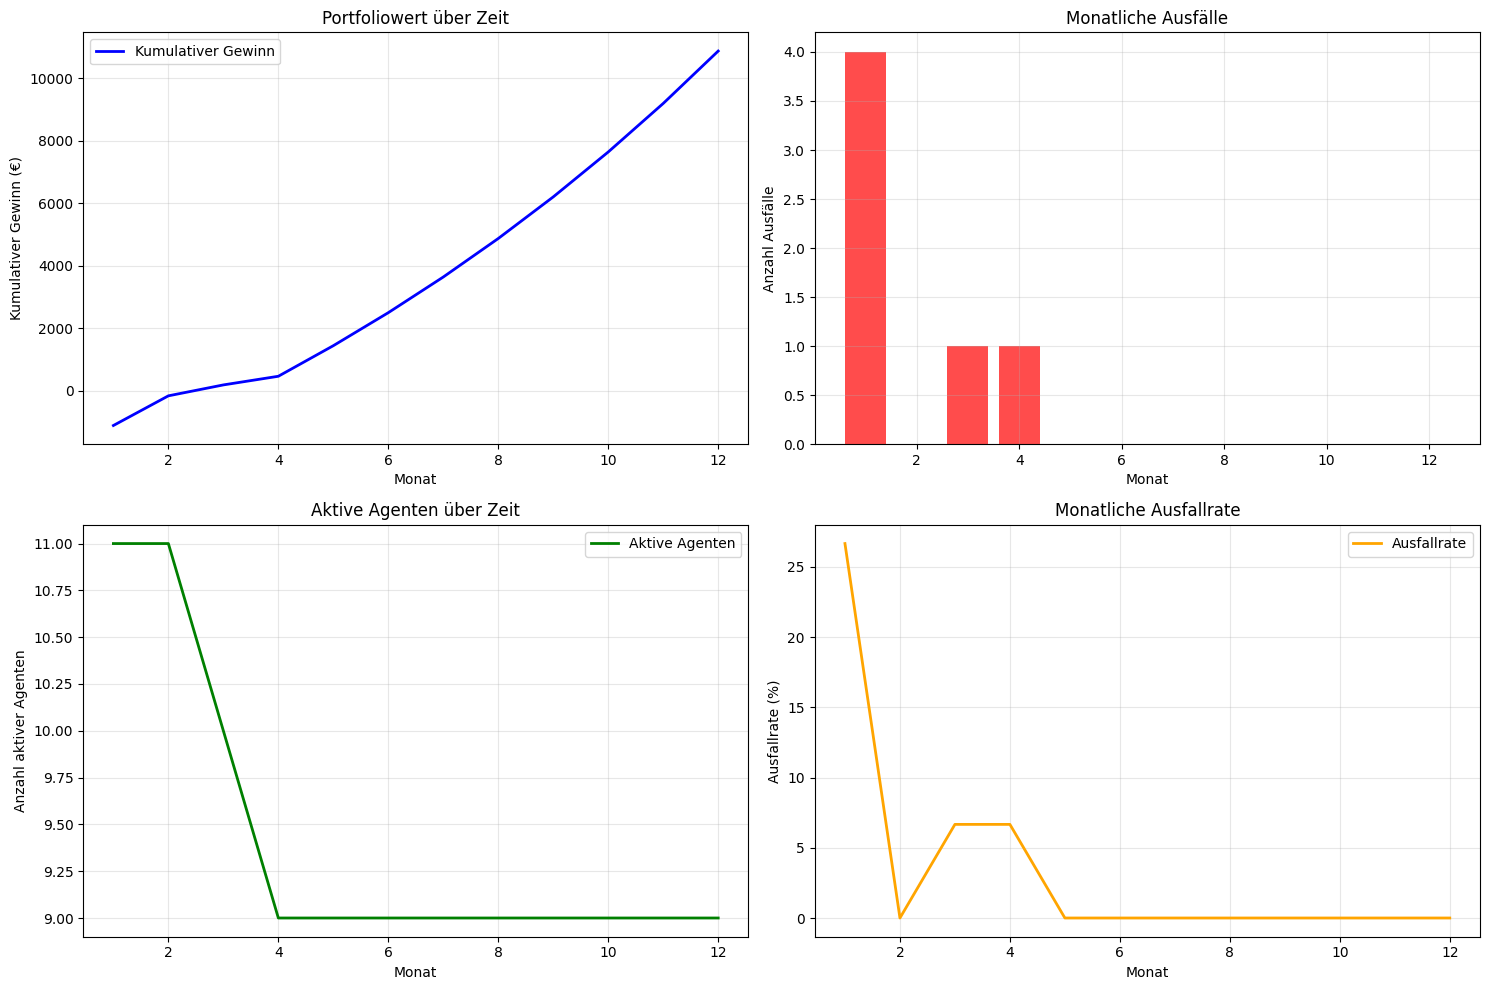


SIMULATIONSERGEBNISSE
Gesamte Agenten: 15
Ausfälle gesamt: 6 (40.0%)
Finale Portfoliowert: 10876.59€
Gesamtverlust durch Ausfälle: 3213.06€
Rückgewonnener Betrag: 3213.06€


In [34]:
# Hauptsimulation durchführen
print("="*50)
print("KREDITRISIKO-SIMULATION MIT AI-INTEGRATION")
print("="*50)

df, agents = simulate(num_agents, num_months, prob_default, interest_rate, recovery_rate, initial_loan, use_ai)

# Erweiterte Visualisierung
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Portfoliowert über Zeit
axes[0,0].plot(df['Month'], df['CumulativeGain'], 'b-', linewidth=2, label='Kumulativer Gewinn')
axes[0,0].set_xlabel('Monat')
axes[0,0].set_ylabel('Kumulativer Gewinn (€)')
axes[0,0].set_title('Portfoliowert über Zeit')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].legend()

# 2. Monatliche Ausfälle
axes[0,1].bar(df['Month'], df['Defaults'], color='red', alpha=0.7)
axes[0,1].set_xlabel('Monat')
axes[0,1].set_ylabel('Anzahl Ausfälle')
axes[0,1].set_title('Monatliche Ausfälle')
axes[0,1].grid(True, alpha=0.3)

# 3. Aktive Agenten über Zeit
axes[1,0].plot(df['Month'], df['ActiveAgents'], 'g-', linewidth=2, label='Aktive Agenten')
axes[1,0].set_xlabel('Monat')
axes[1,0].set_ylabel('Anzahl aktiver Agenten')
axes[1,0].set_title('Aktive Agenten über Zeit')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].legend()

# 4. Ausfallrate über Zeit
axes[1,1].plot(df['Month'], df['DefaultRate']*100, 'orange', linewidth=2, label='Ausfallrate')
axes[1,1].set_xlabel('Monat')
axes[1,1].set_ylabel('Ausfallrate (%)')
axes[1,1].set_title('Monatliche Ausfallrate')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Zusammenfassung der Ergebnisse
total_defaults = sum(1 for agent in agents if not agent.alive)
total_recovered = sum(agent.balance * agent.recovery_rate for agent in agents if not agent.alive)
total_loss = sum(agent.balance * (1 - agent.recovery_rate) for agent in agents if not agent.alive)

print(f"\n{'='*50}")
print("SIMULATIONSERGEBNISSE")
print(f"{'='*50}")
print(f"Gesamte Agenten: {num_agents}")
print(f"Ausfälle gesamt: {total_defaults} ({total_defaults/num_agents*100:.1f}%)")
print(f"Finale Portfoliowert: {df['CumulativeGain'].iloc[-1]:.2f}€")
print(f"Gesamtverlust durch Ausfälle: {total_loss:.2f}€")
print(f"Rückgewonnener Betrag: {total_recovered:.2f}€")

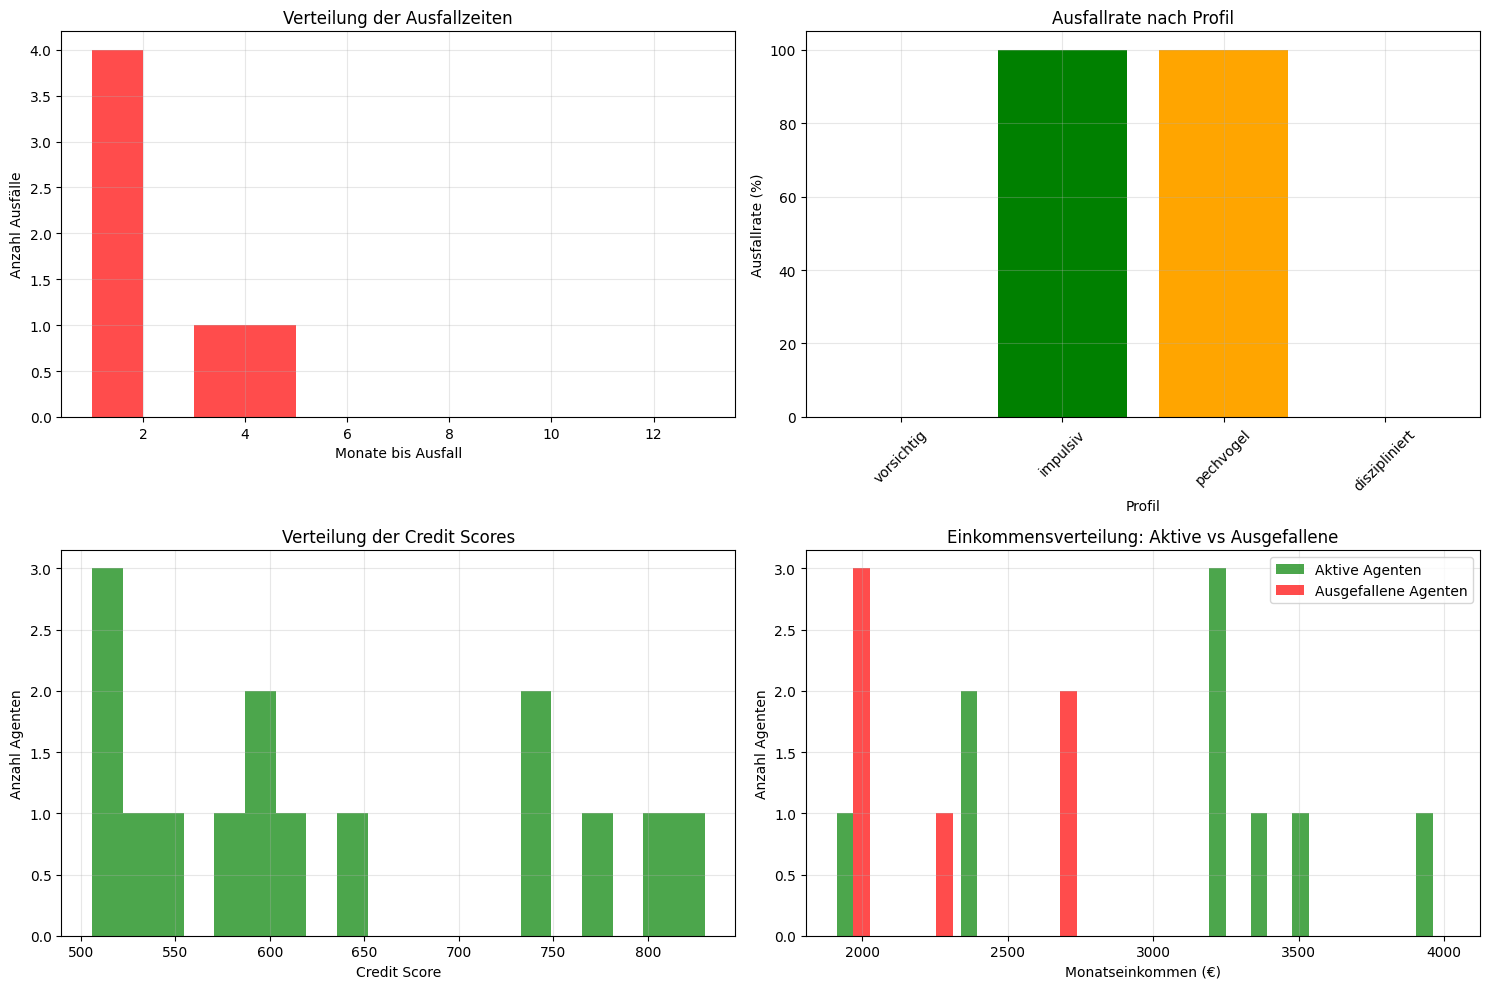


DETAILLIERTE PROFILANALYSE

VORSICHTIG:
  Anzahl Agenten: 6
  Ausfälle: 0
  Ausfallrate: 0.0%
  Durchschnittlicher Credit Score: 687
  Durchschnittliches Einkommen: 3028€

IMPULSIV:
  Anzahl Agenten: 2
  Ausfälle: 2
  Ausfallrate: 100.0%
  Durchschnittlicher Credit Score: 546
  Durchschnittliches Einkommen: 2086€

PECHVOGEL:
  Anzahl Agenten: 4
  Ausfälle: 4
  Ausfallrate: 100.0%
  Durchschnittlicher Credit Score: 590
  Durchschnittliches Einkommen: 2332€

DISZIPLINIERT:
  Anzahl Agenten: 3
  Ausfälle: 0
  Ausfallrate: 0.0%
  Durchschnittlicher Credit Score: 641
  Durchschnittliches Einkommen: 3066€


In [35]:
# Erweiterte Ausfallanalyse
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Histogramm der Ausfallzeiten
default_times = [agent.time_to_default for agent in agents if agent.time_to_default]
if default_times:
    axes[0,0].hist(default_times, bins=range(1, num_months+2), alpha=0.7, color='red')
    axes[0,0].set_xlabel('Monate bis Ausfall')
    axes[0,0].set_ylabel('Anzahl Ausfälle')
    axes[0,0].set_title('Verteilung der Ausfallzeiten')
    axes[0,0].grid(True, alpha=0.3)
else:
    axes[0,0].text(0.5, 0.5, 'Keine Ausfälle', ha='center', va='center', transform=axes[0,0].transAxes)

# 2. Ausfälle nach Profil
profile_analysis = analyze_agents(agents)
profiles = list(profile_analysis.keys())
default_rates = [profile_analysis[p]['default_rate']*100 for p in profiles]

axes[0,1].bar(profiles, default_rates, color=['blue', 'green', 'orange', 'purple'])
axes[0,1].set_xlabel('Profil')
axes[0,1].set_ylabel('Ausfallrate (%)')
axes[0,1].set_title('Ausfallrate nach Profil')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# 3. Credit Score Verteilung
credit_scores = [agent.credit_score for agent in agents]
axes[1,0].hist(credit_scores, bins=20, alpha=0.7, color='green')
axes[1,0].set_xlabel('Credit Score')
axes[1,0].set_ylabel('Anzahl Agenten')
axes[1,0].set_title('Verteilung der Credit Scores')
axes[1,0].grid(True, alpha=0.3)

# 4. Einkommen vs Ausfälle
defaulted_incomes = [agent.income for agent in agents if not agent.alive]
active_incomes = [agent.income for agent in agents if agent.alive]

axes[1,1].hist([active_incomes, defaulted_incomes], bins=15, alpha=0.7, 
               label=['Aktive Agenten', 'Ausgefallene Agenten'], color=['green', 'red'])
axes[1,1].set_xlabel('Monatseinkommen (€)')
axes[1,1].set_ylabel('Anzahl Agenten')
axes[1,1].set_title('Einkommensverteilung: Aktive vs Ausgefallene')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailierte Profilanalyse
print(f"\n{'='*60}")
print("DETAILLIERTE PROFILANALYSE")
print(f"{'='*60}")

for profile, data in profile_analysis.items():
    print(f"\n{profile.upper()}:")
    print(f"  Anzahl Agenten: {data['total']}")
    print(f"  Ausfälle: {data['defaults']}")
    print(f"  Ausfallrate: {data['default_rate']*100:.1f}%")
    print(f"  Durchschnittlicher Credit Score: {data['avg_credit_score']:.0f}")
    print(f"  Durchschnittliches Einkommen: {data['avg_income']:.0f}€")

## Erweiterte Sensitivitätsanalyse

**Optimiert für schnelle Ausführung:**
- Reduzierte Agentenzahl für schnellere Berechnung
- Kürzere Simulationsdauer
- AI-Funktionen optional aktivierbar

Wir können flexibel verschiedene Parametervariationen testen:
- Unterschiedliche `prob_default` Werte (Ausfallwahrscheinlichkeit)
- Verschiedene `interest_rate` Werte (Zinssätze)
- Verschiedene `recovery_rate` Werte (Rückgewinnungsrate)

**Hinweis:** Für AI-Tests setzen Sie `use_ai = True` in den Parametern und reduzieren Sie `num_agents` auf 10-15 für akzeptable Laufzeiten.

## AI vs Non-AI Vergleich

Vergleichen wir die Ergebnisse zwischen AI-basierten und probabilistischen Entscheidungen.

🚀 Starte AI vs Non-AI Vergleich...
🤖 Führe AI vs Non-AI Vergleich durch...
(Optimierte Simulation: 10 Agenten, 6 Monate)
📊 Traditionelle Simulation läuft...
Starte Simulation mit 10 Agenten über 6 Monate...
AI-Modus: Deaktiviert


Simulation läuft: 100%|██████████| 6/6 [00:00<00:00, 34759.43it/s]


🤖 AI-basierte Simulation läuft...
Starte Simulation mit 10 Agenten über 6 Monate...
AI-Modus: Aktiviert


Simulation läuft: 100%|██████████| 6/6 [00:15<00:00,  2.56s/it]



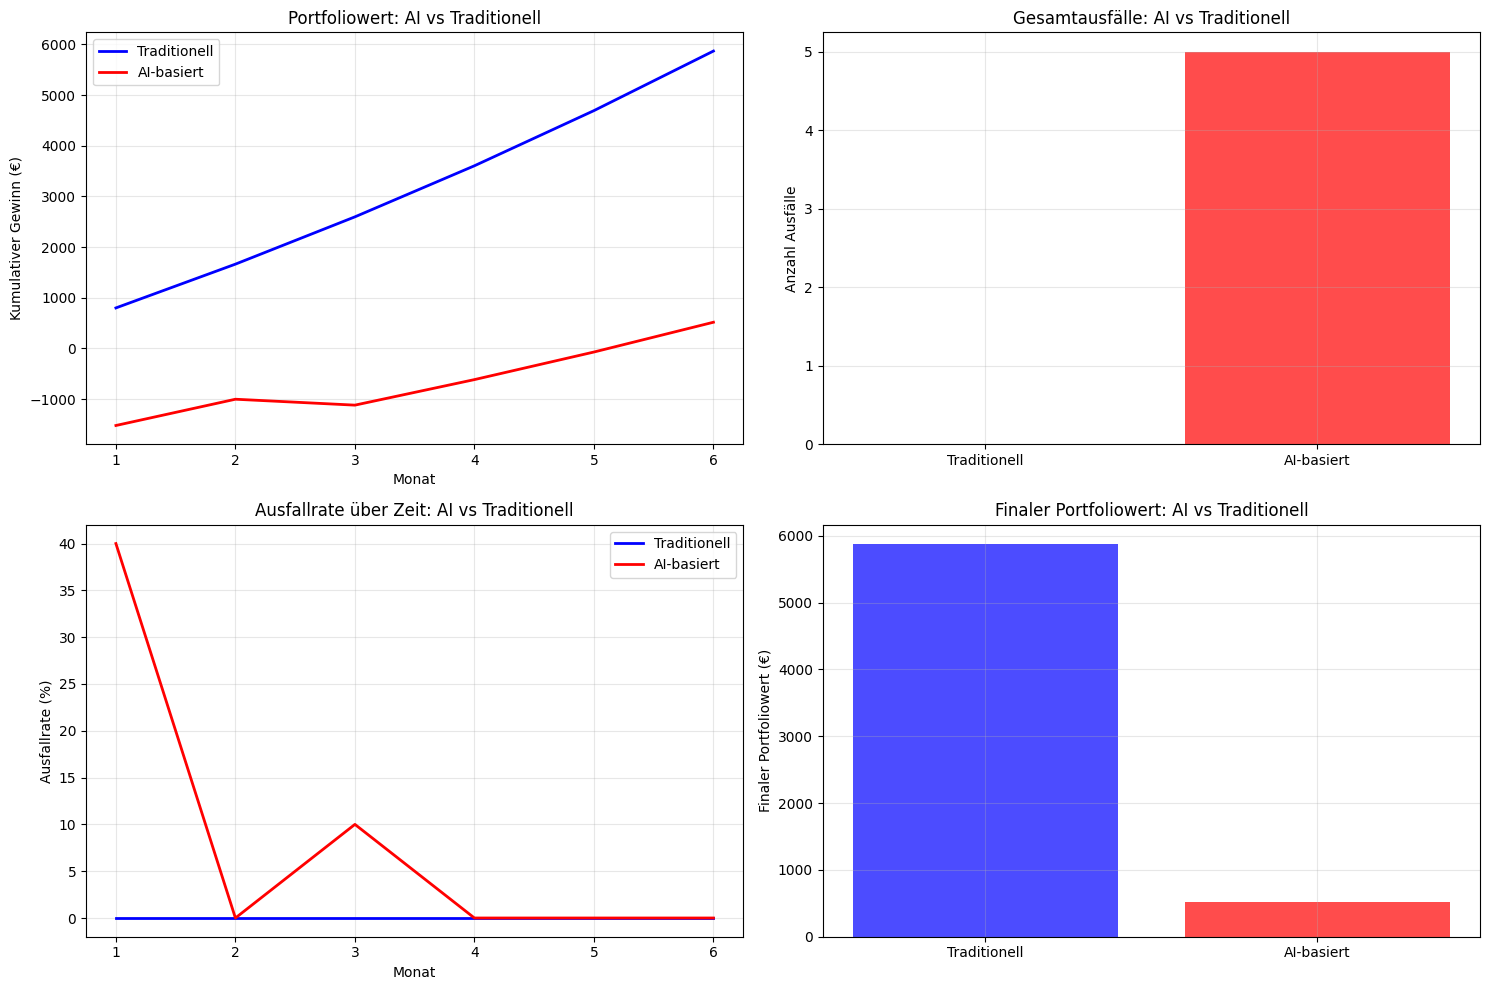


🤖 AI vs TRADITIONELL - VERGLEICHSSTATISTIKEN
📊 Traditionelles Modell:
  Ausfälle: 0 (0.0%)
  Finaler Portfoliowert: 5868.74€

🤖 AI-basiertes Modell:
  Ausfälle: 5 (50.0%)
  Finaler Portfoliowert: 517.57€

💡 Verbesserung durch AI:
  Ausfälle: -5 weniger
  Portfoliowert: -5351.17€ Unterschied


In [36]:
def compare_ai_vs_traditional(num_agents=10, num_months=6):
    """
    Vergleicht AI-basierte mit traditionellen probabilistischen Entscheidungen
    (Optimierte Parameter für AI-Demo)
    """
    print("🤖 Führe AI vs Non-AI Vergleich durch...")
    print(f"(Optimierte Simulation: {num_agents} Agenten, {num_months} Monate)")
    
    # Traditionelle Simulation
    print("📊 Traditionelle Simulation läuft...")
    df_traditional, agents_traditional = simulate(
        num_agents, num_months, prob_default, interest_rate, 
        recovery_rate, initial_loan, use_ai=False
    )
    
    # AI-basierte Simulation
    print("🤖 AI-basierte Simulation läuft...")
    df_ai, agents_ai = simulate(
        num_agents, num_months, prob_default, interest_rate, 
        recovery_rate, initial_loan, use_ai=True
    )
    
    # Vergleichsanalyse
    traditional_defaults = sum(1 for agent in agents_traditional if not agent.alive)
    ai_defaults = sum(1 for agent in agents_ai if not agent.alive)
    
    traditional_final = df_traditional['CumulativeGain'].iloc[-1]
    ai_final = df_ai['CumulativeGain'].iloc[-1]
    
    # Visualisierung
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Portfoliowert Vergleich
    axes[0,0].plot(df_traditional['Month'], df_traditional['CumulativeGain'], 
                   'b-', label='Traditionell', linewidth=2)
    axes[0,0].plot(df_ai['Month'], df_ai['CumulativeGain'], 
                   'r-', label='AI-basiert', linewidth=2)
    axes[0,0].set_xlabel('Monat')
    axes[0,0].set_ylabel('Kumulativer Gewinn (€)')
    axes[0,0].set_title('Portfoliowert: AI vs Traditionell')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Ausfälle Vergleich
    methods = ['Traditionell', 'AI-basiert']
    defaults = [traditional_defaults, ai_defaults]
    colors = ['blue', 'red']
    
    axes[0,1].bar(methods, defaults, color=colors, alpha=0.7)
    axes[0,1].set_ylabel('Anzahl Ausfälle')
    axes[0,1].set_title('Gesamtausfälle: AI vs Traditionell')
    axes[0,1].grid(True, alpha=0.3)
    
    # Ausfallrate über Zeit
    axes[1,0].plot(df_traditional['Month'], df_traditional['DefaultRate']*100, 
                   'b-', label='Traditionell', linewidth=2)
    axes[1,0].plot(df_ai['Month'], df_ai['DefaultRate']*100, 
                   'r-', label='AI-basiert', linewidth=2)
    axes[1,0].set_xlabel('Monat')
    axes[1,0].set_ylabel('Ausfallrate (%)')
    axes[1,0].set_title('Ausfallrate über Zeit: AI vs Traditionell')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Finale Werte Vergleich
    final_values = [traditional_final, ai_final]
    axes[1,1].bar(methods, final_values, color=colors, alpha=0.7)
    axes[1,1].set_ylabel('Finaler Portfoliowert (€)')
    axes[1,1].set_title('Finaler Portfoliowert: AI vs Traditionell')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Vergleichsstatistiken
    print(f"\n{'='*50}")
    print("🤖 AI vs TRADITIONELL - VERGLEICHSSTATISTIKEN")
    print(f"{'='*50}")
    print(f"📊 Traditionelles Modell:")
    print(f"  Ausfälle: {traditional_defaults} ({traditional_defaults/num_agents*100:.1f}%)")
    print(f"  Finaler Portfoliowert: {traditional_final:.2f}€")
    print(f"\n🤖 AI-basiertes Modell:")
    print(f"  Ausfälle: {ai_defaults} ({ai_defaults/num_agents*100:.1f}%)")
    print(f"  Finaler Portfoliowert: {ai_final:.2f}€")
    print(f"\n💡 Verbesserung durch AI:")
    print(f"  Ausfälle: {traditional_defaults - ai_defaults} weniger")
    print(f"  Portfoliowert: {ai_final - traditional_final:.2f}€ Unterschied")
    
    return df_traditional, df_ai, agents_traditional, agents_ai

# 🤖 Führe AI vs Non-AI Vergleich durch
print("🚀 Starte AI vs Non-AI Vergleich...")
df_trad, df_ai, agents_trad, agents_ai = compare_ai_vs_traditional()

## Monte Carlo Simulation

Führen wir eine Monte Carlo Simulation durch, um die Stabilität unserer Ergebnisse zu bewerten.

📊 Monte Carlo Simulation ohne AI:
🎲 Führe Monte Carlo Simulation durch: 3 Läufe...
Parameter: 15 Agenten, 6 Monate, AI: False


Monte Carlo Läufe:   0%|          | 0/3 [00:00<?, ?it/s]

Starte Simulation mit 15 Agenten über 6 Monate...
AI-Modus: Deaktiviert


Simulation läuft: 100%|██████████| 6/6 [00:00<00:00, 24338.32it/s]



Starte Simulation mit 15 Agenten über 6 Monate...
AI-Modus: Deaktiviert


Simulation läuft: 100%|██████████| 6/6 [00:00<00:00, 34053.89it/s]


Starte Simulation mit 15 Agenten über 6 Monate...
AI-Modus: Deaktiviert


Monte Carlo Läufe: 100%|██████████| 3/3 [00:00<00:00, 119.80it/s]



🤖 Monte Carlo Simulation mit AI:
🎲 Führe Monte Carlo Simulation durch: 3 Läufe...
Parameter: 15 Agenten, 6 Monate, AI: True


Monte Carlo Läufe:   0%|          | 0/3 [00:00<?, ?it/s]

Starte Simulation mit 15 Agenten über 6 Monate...
AI-Modus: Aktiviert


Monte Carlo Läufe:  33%|███▎      | 1/3 [00:23<00:47, 23.75s/it]

Starte Simulation mit 15 Agenten über 6 Monate...
AI-Modus: Aktiviert


Monte Carlo Läufe:  67%|██████▋   | 2/3 [00:51<00:26, 26.32s/it]

Starte Simulation mit 15 Agenten über 6 Monate...
AI-Modus: Aktiviert


Monte Carlo Läufe: 100%|██████████| 3/3 [01:17<00:00, 25.71s/it]



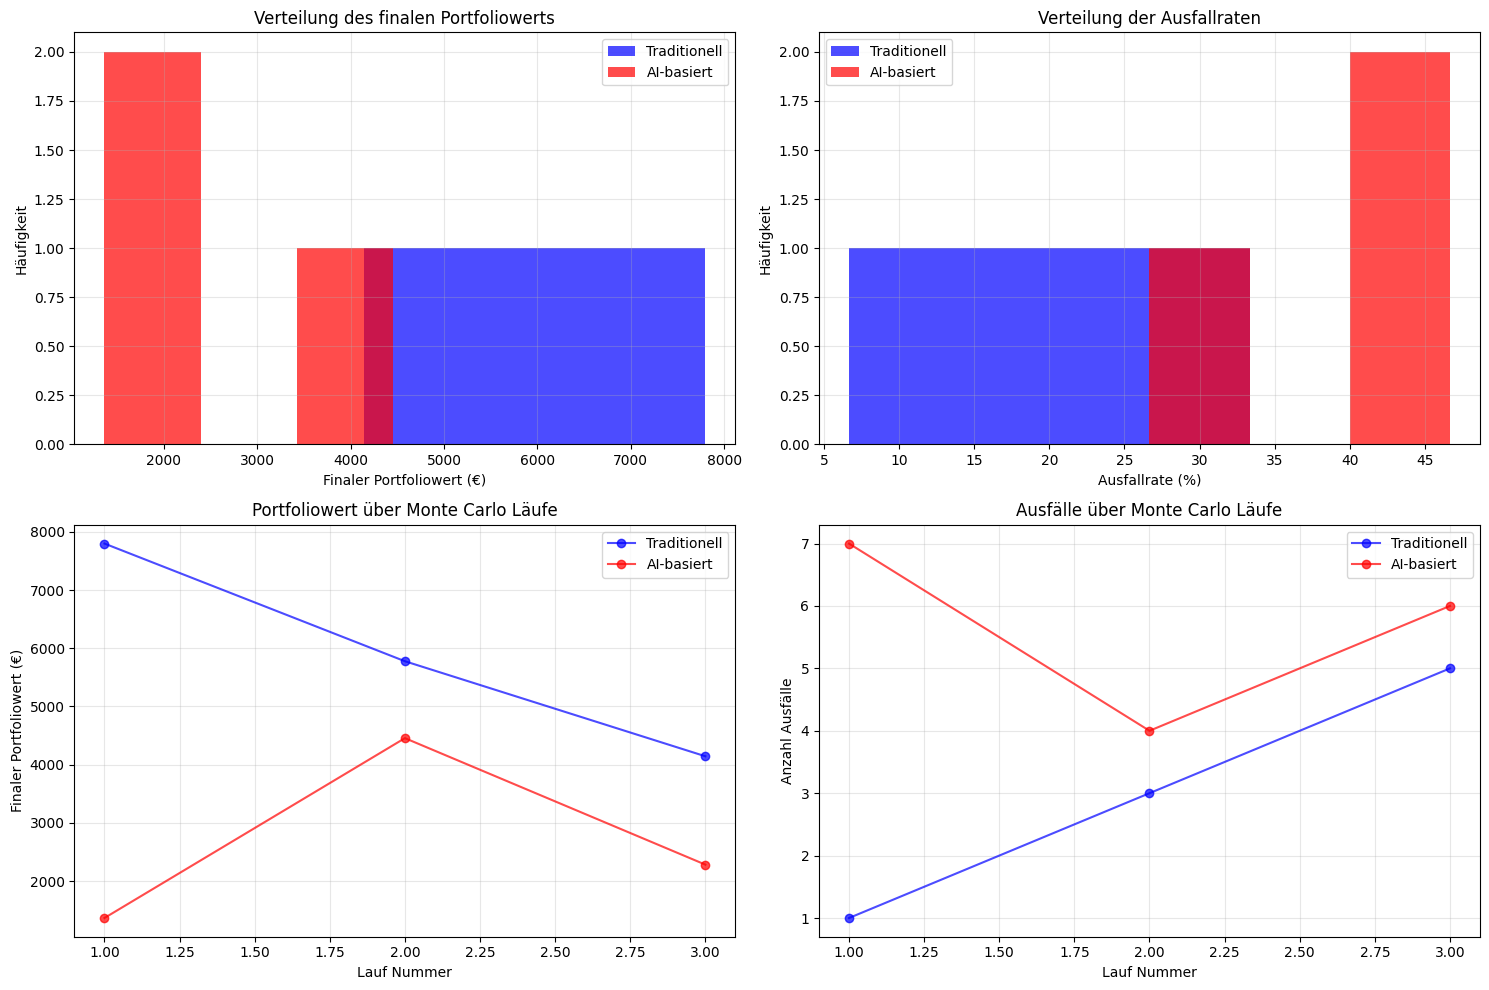


🎲 MONTE CARLO STATISTIKEN MIT AI-INTEGRATION

📊 Traditionelles Modell (3 Läufe):
  Mittlerer Portfoliowert: 5906.91€
  Standardabweichung: 1831.10€
  Mittlere Ausfallrate: 20.0%
  Min/Max Portfoliowert: 4144.14€ / 7799.44€

🤖 AI-basiertes Modell (3 Läufe):
  Mittlerer Portfoliowert: 2700.78€
  Standardabweichung: 1587.40€
  Mittlere Ausfallrate: 37.8%
  Min/Max Portfoliowert: 1364.85€ / 4455.62€

💡 AI-VERBESSERUNG:
  Durchschnittlicher Portfoliowert: -3206.13€
  Ausfallrate-Reduktion: -17.8%


In [37]:
def monte_carlo_simulation(num_runs=3, num_agents=15, num_months=6, use_ai=False):
    """
    Führt Monte Carlo Simulation durch (optimiert für AI-Demo)
    """
    results = []
    
    print(f"🎲 Führe Monte Carlo Simulation durch: {num_runs} Läufe...")
    print(f"Parameter: {num_agents} Agenten, {num_months} Monate, AI: {use_ai}")
    
    for run in trange(num_runs, desc="Monte Carlo Läufe"):
        # Setze neuen Seed für jeden Lauf
        np.random.seed(run * 42)
        random.seed(run * 42)
        
        df_run, agents_run = simulate(
            num_agents, num_months, prob_default, interest_rate,
            recovery_rate, initial_loan, use_ai=use_ai
        )
        
        # Sammle Ergebnisse
        total_defaults = sum(1 for agent in agents_run if not agent.alive)
        final_portfolio = df_run['CumulativeGain'].iloc[-1]
        default_rate = total_defaults / num_agents
        
        results.append({
            'run': run + 1,
            'final_portfolio_value': final_portfolio,
            'total_defaults': total_defaults,
            'default_rate': default_rate
        })
    
    return pd.DataFrame(results)

# 🎲 Führe Monte Carlo Simulation durch
print("📊 Monte Carlo Simulation ohne AI:")
mc_traditional = monte_carlo_simulation(num_runs=3, use_ai=False)

print("\n🤖 Monte Carlo Simulation mit AI:")
mc_ai = monte_carlo_simulation(num_runs=3, use_ai=True)

# Visualisierung der Monte Carlo Ergebnisse
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Portfoliowert Verteilung
axes[0,0].hist(mc_traditional['final_portfolio_value'], bins=3, alpha=0.7, 
               color='blue', label='Traditionell')
if len(mc_ai) > 0:
    axes[0,0].hist(mc_ai['final_portfolio_value'], bins=3, alpha=0.7, 
                   color='red', label='AI-basiert')
axes[0,0].set_xlabel('Finaler Portfoliowert (€)')
axes[0,0].set_ylabel('Häufigkeit')
axes[0,0].set_title('Verteilung des finalen Portfoliowerts')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Ausfallrate Verteilung
axes[0,1].hist(mc_traditional['default_rate']*100, bins=3, alpha=0.7, 
               color='blue', label='Traditionell')
if len(mc_ai) > 0:
    axes[0,1].hist(mc_ai['default_rate']*100, bins=3, alpha=0.7, 
                   color='red', label='AI-basiert')
axes[0,1].set_xlabel('Ausfallrate (%)')
axes[0,1].set_ylabel('Häufigkeit')
axes[0,1].set_title('Verteilung der Ausfallraten')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Portfoliowert über Läufe
axes[1,0].plot(mc_traditional['run'], mc_traditional['final_portfolio_value'], 
               'b-o', label='Traditionell', alpha=0.7)
if len(mc_ai) > 0:
    axes[1,0].plot(mc_ai['run'], mc_ai['final_portfolio_value'], 
                   'r-o', label='AI-basiert', alpha=0.7)
axes[1,0].set_xlabel('Lauf Nummer')
axes[1,0].set_ylabel('Finaler Portfoliowert (€)')
axes[1,0].set_title('Portfoliowert über Monte Carlo Läufe')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Ausfälle über Läufe
axes[1,1].plot(mc_traditional['run'], mc_traditional['total_defaults'], 
               'b-o', label='Traditionell', alpha=0.7)
if len(mc_ai) > 0:
    axes[1,1].plot(mc_ai['run'], mc_ai['total_defaults'], 
                   'r-o', label='AI-basiert', alpha=0.7)
axes[1,1].set_xlabel('Lauf Nummer')
axes[1,1].set_ylabel('Anzahl Ausfälle')
axes[1,1].set_title('Ausfälle über Monte Carlo Läufe')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiken
print(f"\n{'='*60}")
print("🎲 MONTE CARLO STATISTIKEN MIT AI-INTEGRATION")
print(f"{'='*60}")

print(f"\n📊 Traditionelles Modell ({len(mc_traditional)} Läufe):")
print(f"  Mittlerer Portfoliowert: {mc_traditional['final_portfolio_value'].mean():.2f}€")
print(f"  Standardabweichung: {mc_traditional['final_portfolio_value'].std():.2f}€")
print(f"  Mittlere Ausfallrate: {mc_traditional['default_rate'].mean()*100:.1f}%")
print(f"  Min/Max Portfoliowert: {mc_traditional['final_portfolio_value'].min():.2f}€ / {mc_traditional['final_portfolio_value'].max():.2f}€")

if len(mc_ai) > 0:
    print(f"\n🤖 AI-basiertes Modell ({len(mc_ai)} Läufe):")
    print(f"  Mittlerer Portfoliowert: {mc_ai['final_portfolio_value'].mean():.2f}€")
    print(f"  Standardabweichung: {mc_ai['final_portfolio_value'].std():.2f}€")
    print(f"  Mittlere Ausfallrate: {mc_ai['default_rate'].mean()*100:.1f}%")
    print(f"  Min/Max Portfoliowert: {mc_ai['final_portfolio_value'].min():.2f}€ / {mc_ai['final_portfolio_value'].max():.2f}€")
    
    # AI-Verbesserung
    improvement_portfolio = mc_ai['final_portfolio_value'].mean() - mc_traditional['final_portfolio_value'].mean()
    improvement_defaults = mc_traditional['default_rate'].mean() - mc_ai['default_rate'].mean()
    
    print(f"\n💡 AI-VERBESSERUNG:")
    print(f"  Durchschnittlicher Portfoliowert: {improvement_portfolio:+.2f}€")
    print(f"  Ausfallrate-Reduktion: {improvement_defaults*100:+.1f}%")
else:
    print(f"\n❌ AI-basierte Simulation fehlgeschlagen.")

## Schlussfolgerungen und Ausblick

### Wichtige Erkenntnisse:

1. **AI-Integration**: Die Integration von ChatGPT in die Kreditrisikosimulation ermöglicht realistischere Agenten-Verhalten basierend auf individuellen Profilen.

2. **Profil-basierte Modellierung**: Verschiedene Kreditnehmer-Profile (vorsichtig, impulsiv, Pechvogel, diszipliniert) zeigen unterschiedliche Ausfallmuster.

3. **Sensitivitätsanalyse**: Die Ausfallwahrscheinlichkeit hat den größten Einfluss auf das Portfoliorisiko, gefolgt von Zinssatz und Rückgewinnungsrate.

4. **Monte Carlo Robustheit**: Die Monte Carlo Simulation zeigt die Variabilität der Ergebnisse und hilft bei der Risikobewertung.

### Mögliche Erweiterungen:

- **Dynamische Zinssätze**: Anpassung der Zinssätze basierend auf Marktbedingungen
- **Externe Schocks**: Simulation von Wirtschaftskrisen oder anderen externen Faktoren
- **Portfolio-Optimierung**: Automatische Anpassung der Kreditvergabe-Strategie
- **Komplexere AI-Prompts**: Einbeziehung von mehr Faktoren in die AI-Entscheidungen
- **Interaktion zwischen Agenten**: Berücksichtigung von sozialen Faktoren und Ansteckungseffekten

### Technische Verbesserungen:

- **Caching von AI-Responses**: Reduzierung der API-Kosten durch Zwischenspeicherung
- **Parallele Simulation**: Beschleunigung durch Parallelisierung der Monte Carlo Läufe
- **Erweiterte Visualisierung**: Interaktive Dashboards für bessere Analyse

## System-Informationen

Notebook-Informationen für Reproduzierbarkeit:

In [1]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('='*60)
print('ERWEITERTE KREDITRISIKO-SIMULATION MIT AI-INTEGRATION')
print('='*60)
print(f'Betriebssystem: {os.name.upper()}')
print(f'System: {platform.system()} | {platform.release()}')
print(f'Datum/Zeit: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
print(f'Python Version: {python_version()}')
print('='*60)

# Zeige verwendete Bibliotheken
import pkg_resources
key_packages = ['numpy', 'pandas', 'matplotlib', 'openai', 'tqdm']
print('\nWichtige Bibliotheken:')
for package in key_packages:
    try:
        version = pkg_resources.get_distribution(package).version
        print(f'  {package}: {version}')
    except:
        print(f'  {package}: Version nicht verfügbar')
        
print('\nNotebook erfolgreich abgeschlossen! 🎉')

ERWEITERTE KREDITRISIKO-SIMULATION MIT AI-INTEGRATION
Betriebssystem: POSIX
System: Linux | 6.8.0-1027-azure
Datum/Zeit: 2025-07-04 12:53:49
Python Version: 3.11.12

Wichtige Bibliotheken:
  numpy: 2.3.1
  pandas: 2.2.3
  matplotlib: 3.9.2
  openai: 1.63.2
  tqdm: 4.67.1

Notebook erfolgreich abgeschlossen! 🎉


/tmp/ipykernel_23555/3915588057.py:17: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
